In [1]:
import cv2
import dask as d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob

In [2]:
from fl_tissue_model_tools import dev_config, defs, data_prep
from fl_tissue_model_tools import preprocessing as prep

In [3]:
dirs = dev_config.get_dev_directories("../dev_paths.txt")

In [4]:
cell_image_dir = f"{dirs.data_dir}/coverage_area/hmvec"
thresh_cell_image_output_dir = f"{dirs.figures_dir}/coverage_area/2022_03_29_hmvec"
cell_image_area_output_dir = f"{dirs.analysis_dir}/coverage_area/2022_03_29_hmvec"

In [6]:
# Make write-out directories or overwrite them
data_prep.make_dir(thresh_cell_image_output_dir)
data_prep.make_dir(cell_image_area_output_dir)

In [7]:
dsamp_size = 250
sd_coef = 0 # threshold takes all pixels {sd_coefs} standard deviations above the mean of the foreground Gaussian
pinhole_cut = 10 # the radius of the circle mask is ({dsamp_size}//2 -  {pinhole_cut})

# Functions

In [8]:
def load_img(img_name, dsamp=True, dsize=250):
    '''
        Load the image {img_name} and downsample if {dsamp}
    '''
    # cv.IMREAD_ANYDEPTH loads the image as a 16 bit grayscale image
    img = cv2.imread(img_name, cv2.IMREAD_ANYDEPTH)
    if dsamp:
        return cv2.resize(img, dsize, cv2.INTER_AREA)
    else:
        return img


def load_and_norm(img_name, a, b, mn, mx, dsamp=True, dsize=250):
    img = load_img(img_name, dsamp=True, dsize=dsize)
    return prep.min_max_(img, a, b, mn, mx)


def mask_and_threshold(img, circ_mask, pinhole_idx, sd_coef, rs):
    '''
        Apply the circle mask {circ_mask} to the image {img}
        and then perform foreground thresholding on the masked image
    '''
    masked = prep.apply_mask(img, circ_mask).astype(float)
    return prep.exec_threshold(masked, pinhole_idx, sd_coef, rs)


def compute_area_prop(img, ref_area):
    return np.sum(img > 0) / ref_area

# Retrieve images

In [10]:
img_names = [img.replace("\\", "/") for img in glob(f"{cell_image_dir}/*.tif")]

In [11]:
gs_ds_imgs = d.compute(
    # [d.delayed(load_and_norm)(img_n, gs_min, gs_max, tif_min, tif_max, dsamp=True, dsize=(dsamp_size, dsamp_size)) for img_n in img_names]
    [d.delayed(load_and_norm)(img_n, defs.GS_MIN, defs.GS_MAX, defs.TIF_MIN, defs.TIF_MAX, dsamp=True, dsize=(dsamp_size, dsamp_size)) for img_n in img_names]
)[0]

In [12]:
# variables for image masking
img_shape = gs_ds_imgs[0].shape
img_center = (img_shape[0] // 2, img_shape[1] // 2)
circ_rad = img_center[0] - (pinhole_cut)
circ_mask = prep.gen_circ_mask(img_center, circ_rad, img_shape, defs.GS_MAX)
pinhole_idx = np.where(circ_mask > 0)
circ_pix_area = np.sum(circ_mask > 0)

In [13]:
rs_all = np.random.RandomState(seed=123)
gmm_masked_all = d.compute(
    [d.delayed(mask_and_threshold)(img, circ_mask, pinhole_idx, sd_coef, rs_all)
     for img in gs_ds_imgs]
)[0]

In [14]:
area_prop = d.compute(
    [d.delayed(compute_area_prop)(gimg, circ_pix_area) for gimg in gmm_masked_all]
)[0]
area_prop = np.array(area_prop)

In [15]:
img_ids = [img_n.split("/")[-1][:-4] for img_n in img_names]
area_df = pd.DataFrame(
    data = {"image_id": img_ids, "area_pct": area_prop * 100}
)

In [16]:
target_idx = 120

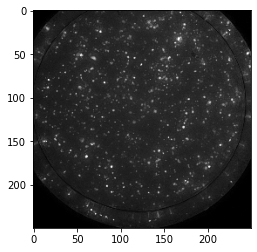

In [17]:
plt.imshow(gs_ds_imgs[target_idx], cmap="gray")
plt.show()

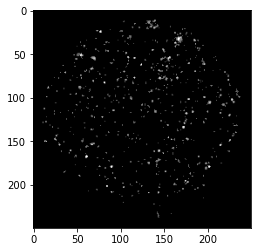

In [18]:
plt.imshow(gmm_masked_all[target_idx], cmap="gray")
plt.show()

# Save results

In [24]:
for i in range(len(img_ids)):
    cv2.imwrite(
        f"{thresh_cell_image_output_dir}/{img_ids[i]}_processed.tif",
        prep.min_max_(gmm_masked_all[i], defs.TIF_MIN, defs.TIF_MAX, defs.GS_MIN, defs.GS_MAX).astype(np.uint16)
    )
area_df.to_csv(f"{cell_image_area_output_dir}/area_results.csv", index=False)